# **Step 1: test out how well SAM does with construction lines**

shouldn't be too hard to use my existing "open sketch dataset" -> might involve a bit more work "importing" this data but doable

I will first start with pseudocoding = easier for me to understand:


# Overview

# What SAM Expects
SAM expects:


*   an RGB image as a NumPy array

*   Shape: (H,W,3) = 3 color channels
*   Data Type: uint8 with vals inthe range [0,255]

What Dataset contains
*   .png files that transparency (alpha channel = 4th channel in img that controls transparency); so, some images are RGBA not RGB



# 1. Setting Up Everything

Use nvidia-smi command to make sure we have access to GPU

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


install SAM and other programs

In [ ]:
# installing SAM and other necessary programs
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git' #SAM
!pip install -q jupyter_bbox_widget #can draw and interact with bounding boxes
!pip install -q dataclasses-json #convert dataclasses to JSON to represent masks,points, or settings
!pip install -q supervision==0.23.0 #visualize masks, annotate imgs, etc.

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 9.5 MB/s eta 0:00:00


import everything

In [ ]:
import os # for managing file paths and directories
import torch # for using SAM that uses PyTorch
import cv2 # tool for for image processing and  (ex: OpenCV)
import supervision as sv # helps to visualize SAM's output
import numpy as np # format SAM expects of numpy array
import matplotlib.pyplot as plt # for plotting images
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator # the neural network we will use for img segmentation

create working directory to manage datasets, images and models we create a HOME constant

* defines working directory I will be using
  * os.getcwd() = "get current working directory"
* CHECKPOINT_PATH  
  * os.path.join(...) = joins together:
    * HOME (base folder)
    * "weights" = subfolder where you saved the .pth file
    * "sam_vit.." your model weights file
  - checkpoint = saved snapshot of model at a certain point of trianing including
      * model's weights (state_dict)
      * (optional) optimizer state
      * (optional) current epoch or loss
      * checkpoints are used to deploy the model, eval, and fine-tune it
  - in this case, the model_weights_path is just used to load the model

  - .pth file in PyTorch = "PyTorch" checkpoint file (storing model's trained weights and like training progress)
  - vit_h = Vision Transformer, Huge
* the GPU that will be used to run neural network efficiently
* choosing which ViT (vision transformer) will use (ViT_h)

In [ ]:
HOME = os.getcwd()

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights
CHECKPOINT_FILENAME = "sam_vit_h_4b8939.pth"
CHECKPOINT_PATH  = os.path.join(HOME, "weights", CHECKPOINT_FILENAME)

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

MODEL_TYPE = "vit_h"

In [ ]:
# loads the SAM model using registry dictionary
# moves model to GPU for faster processing
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

# enables zero-shot segmentation (aka, no prompting or fine-tuning)
mask_generator = SamAutomaticMaskGenerator(sam)

# 2. Load OpenSketch Data

defines a function that takes:
*   image_path = path to an img file (a sketch)
*   mask_generator = SAM mask
* cv2.IMREAD_UNCHANGED ensures alpha channels (transparency) are preserved if present.
* If the image has 4 channels (RGBA), it's converted to BGR (drops alpha) to make it compatible with later functions.
* Converts the image from OpenCV's default BGR format to RGB, which SAM expects.
* Generates segmentation masks using the SAM model. sam_result contains the masks and metadata for all detected segments.
* detections = sv.Detections.from_sam(sam_result=sam_result)
* mask_annotator = sv.MaskAnnotator()
* Annotates a copy of the original image with the masks (e.g., colored overlays, contours)
* Plots the original image and the annotated image side by side in a grid Helps visually compare the raw input with the segmentation output


In [ ]:
from zipfile import ZipFile
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
for root, dirs, files in os.walk("/content/drive/MyDrive"):
    for file in files:
        if "Open_Sketch_Dataset" in file:
            print(os.path.join(root, file))

!unzip "/content/drive/MyDrive/Project /Open_Sketch_Dataset copy.zip" -d "/content/Open_Sketch_Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/svgs_rendering_uniform/wobble_surface_Professional4.svg  
  inflating: /content/Open_Sketch_Dataset/__MACOSX/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/svgs_rendering_uniform/._wobble_surface_Professional4.svg  
  inflating: /content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/svgs_rendering_uniform/flange_Professional6.svg  
  inflating: /content/Open_Sketch_Dataset/__MACOSX/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/svgs_rendering_uniform/._flange_Professional6.svg  
  inflating: /content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/s

# Finding Specific Sketches

In [ ]:
DATASET_PATH = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint"
sketch_data = find_concept_opaque_sketches(DATASET_PATH)


In [ ]:
def find_concept_opaque_sketches(base_dir, view="view1"):
    """
    Traverse artist folders and collect only 'view1_concept_opaque.png' files,
    grouped by artist type (Professional/Student), then artist name, then object name.

    Args:
        base_dir (str): Path to 'sketches_first_viewpoint' directory
        view (str): View name prefix (default is 'view1')

    Returns:
        dict[artist_type][artist_name][object_name] = full path to PNG
    """
    sketch_dict = {"Professional": {}, "Student": {}}
    target_suffix = f"{view}_concept_opaque.png"

    for artist_folder in os.listdir(base_dir):
        artist_path = os.path.join(base_dir, artist_folder)
        if not os.path.isdir(artist_path):
            continue

        # Determine artist type from folder name
        if "professional" in artist_folder.lower():
            artist_type = "Professional"
        elif "student" in artist_folder.lower():
            artist_type = "Student"
        else:
            continue  # Skip folders that don't match

        # Initialize sub-dict
        sketch_dict[artist_type][artist_folder] = {}

        # Go through object folders
        for object_folder in os.listdir(artist_path):
            object_path = os.path.join(artist_path, object_folder)
            if not os.path.isdir(object_path):
                continue

            # Look for the desired PNG
            for file in os.listdir(object_path):
                if file.endswith(target_suffix):
                    full_path = os.path.join(object_path, file)
                    sketch_dict[artist_type][artist_folder][object_folder] = full_path
                    break  # Only need one match per object

    return sketch_dict

sketch_data = find_concept_opaque_sketches(DATASET_PATH)
for artist_type in sketch_data:
    print(f"🧑‍🎨 {artist_type}: {len(sketch_data[artist_type])} artists")

# IT WORKED LMAOOOOOOOOOOOO

🧑‍🎨 Professional: 6 artists
🧑‍🎨 Student: 9 artists


# Run SAM on One Sketch and Visualize

In [ ]:
def generate_and_visualize_masks(image_path, mask_generator):
    # Load the image (including alpha if present)
    image_bgr = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if image_bgr is None:
        raise ValueError(f"Could not read image at: {image_path}")

    # Handle 4-channel (BGRA) → convert to 3-channel BGR
    if len(image_bgr.shape) == 3 and image_bgr.shape[-1] == 4:
        image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_BGRA2BGR)

    # Reject grayscale or unsupported formats
    elif len(image_bgr.shape) == 2 or image_bgr.shape[-1] != 3:
        raise ValueError("Unsupported image format. Must be 3-channel BGR or 4-channel BGRA.")

    # Convert to RGB for SAM
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate SAM mask
    sam_result = mask_generator.generate(image_rgb)
    detections = sv.Detections.from_sam(sam_result=sam_result)

    # 🔧 Fix missing class_id error
    detections.class_id = [0] * len(detections)

    # Annotate and plot
    mask_annotator = sv.MaskAnnotator()
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Use matplotlib to avoid backend issues in Colab
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title("SAM Segmentation")
    axs[1].axis("off")
    plt.show()



Step-by-step:

cv2.imread(..., cv2.IMREAD_UNCHANGED) keeps the alpha channel (transparency), important for presentation_opaque.png.

if image has 4 channels: strip alpha channel for SAM (it only accepts RGB).

cv2.cvtColor(..., COLOR_BGR2RGB): convert to RGB since OpenCV reads BGR.

mask_generator.generate: runs SAM to generate masks with no prompt.

sv.Detections.from_sam: converts output to a format that the Supervision annotator understands.

sv.plot_images_grid: shows original vs. masked image side by side.



Test One Concept and One Presentation Sketch

In [ ]:
concept_sketches = find_sketch_paths(DATASET_PATH, mode="concept", opaque=True)
presentation_sketches = find_sketch_paths(DATASET_PATH, mode="presentation", opaque=True)

print(f"Found {len(concept_sketches)} concept sketches")
print(f"Found {len(presentation_sketches)} presentation sketches")

generate_and_visualize_masks(concept_sketches[0], mask_generator)
generate_and_visualize_masks(presentation_sketches[0], mask_generator)

NameError: name 'find_sketch_paths' is not defined

First loads a "construction + descriptive lines" sketch (concept).

Then loads a "only descriptive lines" sketch (presentation).

Passes each into SAM + visualizer.This gives you a visual and qualitative sense of how SAM does across sketch types.

In [ ]:
def generate_and_visualize_masks(image_path, mask_generator):
    # Load the image (including alpha if present)
    image_bgr = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if image_bgr is None:
        raise ValueError(f"Could not read image at: {image_path}")

    # Handle 4-channel (BGRA) → convert to 3-channel BGR
    if len(image_bgr.shape) == 3 and image_bgr.shape[-1] == 4:
        image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_BGRA2BGR)

    # Reject grayscale or unsupported formats
    elif len(image_bgr.shape) == 2 or image_bgr.shape[-1] != 3:
        raise ValueError("Unsupported image format. Must be 3-channel BGR or 4-channel BGRA.")

    # Convert to RGB for SAM
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, high_contrast = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    image_rgb = cv2.cvtColor(high_contrast, cv2.COLOR_GRAY2RGB)

    # Generate SAM mask
    sam_result = mask_generator.generate(image_rgb)
    detections = sv.Detections.from_sam(sam_result=sam_result)

    # 🔧 Fix missing class_id error
    detections.class_id = [0] * len(detections)

    # Annotate and plot
    mask_annotator = sv.MaskAnnotator()
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Use matplotlib to avoid backend issues in Colab
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title("SAM Segmentation")
    axs[1].axis("off")
    plt.show()

Found 107 concept sketches
Found 107 presentation sketches


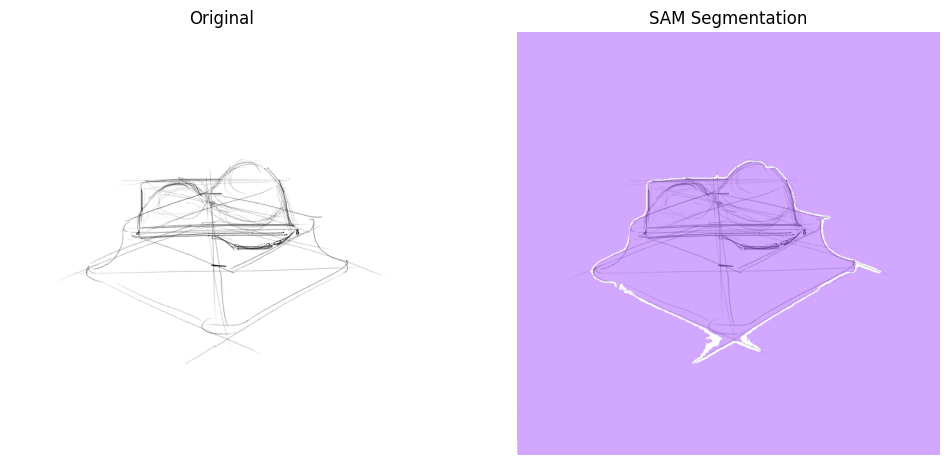

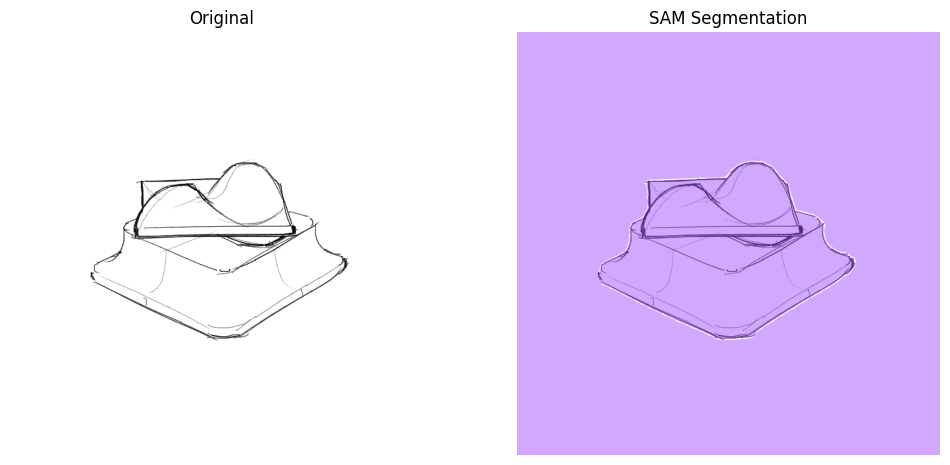

In [ ]:
concept_sketches = find_sketch_paths(DATASET_PATH, mode="concept", opaque=True)
presentation_sketches = find_sketch_paths(DATASET_PATH, mode="presentation", opaque=True)

print(f"Found {len(concept_sketches)} concept sketches")
print(f"Found {len(presentation_sketches)} presentation sketches")

generate_and_visualize_masks(concept_sketches[0], mask_generator)
generate_and_visualize_masks(presentation_sketches[0], mask_generator)

This function below produces black and white mask of object

In [ ]:
def generate_and_visualize_masks_black_and_white(image_path, mask_generator):
    image_bgr = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if image_bgr is None:
        raise ValueError(f"Could not read image at {image_path}")

    if len(image_bgr.shape) == 3 and image_bgr.shape[-1] == 4:
        image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_BGRA2BGR)
    elif len(image_bgr.shape) == 2 or image_bgr.shape[-1] != 3:
        raise ValueError("Unsupported image format.")

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Run SAM
    sam_result = mask_generator.generate(image_rgb)

    # Create black-and-white binary mask from first result
    binary_mask = sam_result[0]["segmentation"].astype("uint8") * 255

    # Show or save the binary mask
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Black-and-White Mask")
    plt.axis("off")
    plt.show()

    detections = sv.Detections.from_sam(sam_result=sam_result)
    detections.class_id = [0] * len(detections)  # Fix missing class_id
    mask_annotator = sv.MaskAnnotator()
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Final plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title("SAM Segmentation")
    axs[1].axis("off")
    plt.show()

generate_and_visualize_masks_black_and_white(concept_sketches[0], mask_generator)
generate_and_visualize_masks_black_and_white(presentation_sketches[0], mask_generator)

NameError: name 'concept_sketches' is not defined

In [ ]:
# Load both images
def get_matching_sketch_pair(base_dir):
    for root, _, files in os.walk(base_dir):
        if "view1_concept_opaque.png" in files and "view1_presentation_opaque.png" in files:
            return (
                os.path.join(root, "view1_concept_opaque.png"),
                os.path.join(root, "view1_presentation_opaque.png"),
            )
    return None, None


full_path, clean_path = get_matching_sketch_pair(DATASET_PATH)
print("Full sketch path:", full_path)
print("Final sketch path:", clean_path)

Full sketch path: /content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/student6/house/view1_concept_opaque.png
Final sketch path: /content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/student6/house/view1_presentation_opaque.png


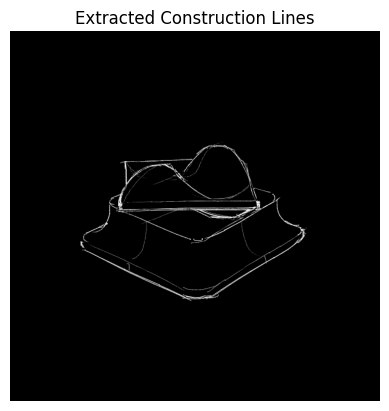

In [ ]:
full_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_concept_opaque.png"
clean_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_presentation_opaque.png"

# Load grayscale images
full = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)

# Ensure both loaded and same shape
if full is None or clean is None:
    print("One or both images couldn't be loaded.")
elif full.shape != clean.shape:
    print("Image shapes don't match:", full.shape, clean.shape)
else:
    # Subtract to get construction-only lines
    construction_only = cv2.subtract(full, clean)

    # Show result
    plt.imshow(construction_only, cmap="gray")
    plt.title("Extracted Construction Lines")
    plt.axis("off")
    plt.show()
# THIS IS WRONG, there should be much more lines for extracted construction lines

There is a 255 pixel difference between the construction lines and object lines

In [ ]:
import numpy as np
diff = np.abs(full.astype(int) - clean.astype(int))
print("Max pixel difference:", np.max(diff))

Max pixel difference: 255


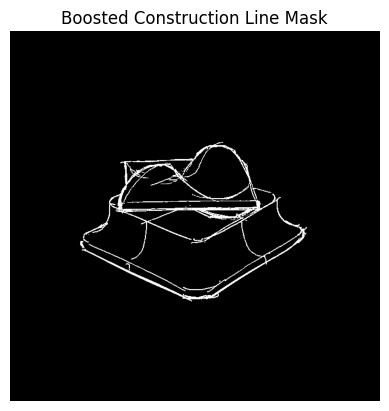

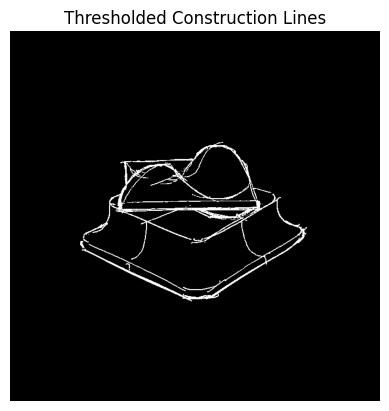

In [ ]:
construction_only = cv2.subtract(full, clean)
# Stretch the difference to full intensity
enhanced = cv2.convertScaleAbs(construction_only, alpha=100.0, beta=0)  # alpha 2–5 is typical

plt.imshow(enhanced, cmap="gray")
plt.title("Boosted Construction Line Mask")
plt.axis("off")
plt.show()

clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
clahe_applied = clahe.apply(construction_only)

_, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY)  # 20–50 is typical range

plt.imshow(thresholded, cmap="gray")
plt.title("Thresholded Construction Lines")
plt.axis("off")
plt.show()

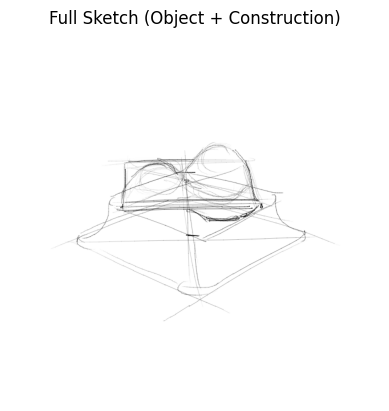

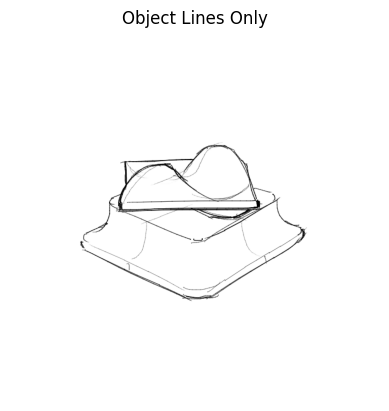

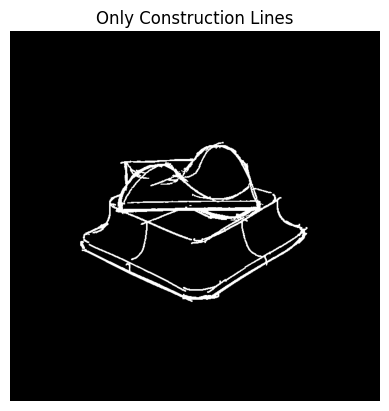

In [ ]:
full_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_concept_opaque.png"
clean_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_presentation_opaque.png"
full = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(full, cmap="gray")
plt.title("Full Sketch (Object + Construction)")
plt.axis("off")
plt.show()

clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(clean, cmap="gray")
plt.title("Object Lines Only")
plt.axis("off")
plt.show()

# Subtract object-only from full sketch
construction_raw = cv2.subtract(full, clean)

# Boost faint lines
boosted = cv2.convertScaleAbs(construction_raw, alpha=15.0)

# Optional CLAHE
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
boosted = clahe.apply(boosted)

# Threshold to clean up noise
_, construction_mask = cv2.threshold(boosted, 5, 255, cv2.THRESH_BINARY)

# Optional dilation
kernel = np.ones((2,2), np.uint8)
construction_final = cv2.dilate(construction_mask, kernel, iterations=1)

# Show
plt.imshow(construction_final, cmap="gray")
plt.title("Only Construction Lines")
plt.axis("off")
plt.show()

✅ Images loaded and same size: (691, 691)


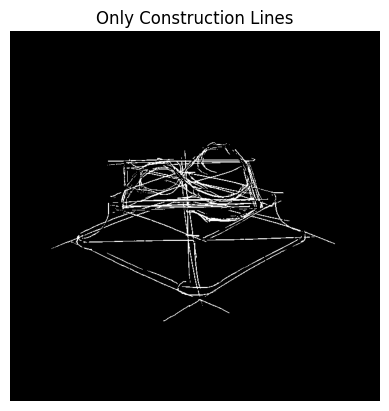

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths
full_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_concept_opaque.png"
clean_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_presentation_opaque.png"

# Load and convert to grayscale
full = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)

# Check if images loaded successfully
if full is None or clean is None:
    print("❌ One or both images could not be loaded.")
    print("Full path:", full_path, "| Loaded:", full is not None)
    print("Clean path:", clean_path, "| Loaded:", clean is not None)
else:
    # Now safe to access shape
    if full.shape != clean.shape:
        print("Shape mismatch:", full.shape, clean.shape)
    else:
        print("✅ Images loaded and same size:", full.shape)

# Ensure same size
if full.shape != clean.shape:
    print("Shape mismatch:", full.shape, clean.shape)

# Invert so lines are white on black
full_inv = cv2.bitwise_not(full)
clean_inv = cv2.bitwise_not(clean)

# Subtract to isolate construction lines
construction = cv2.subtract(full_inv, clean_inv)

# Optional: Boost contrast
construction_boost = cv2.convertScaleAbs(construction, alpha=2.0, beta=0)

# Optional: Threshold to binarize
_, construction_thresh = cv2.threshold(construction_boost, 25, 255, cv2.THRESH_BINARY)

# Display result
plt.imshow(construction_thresh, cmap='gray')
plt.title("Only Construction Lines")
plt.axis('off')
plt.show()

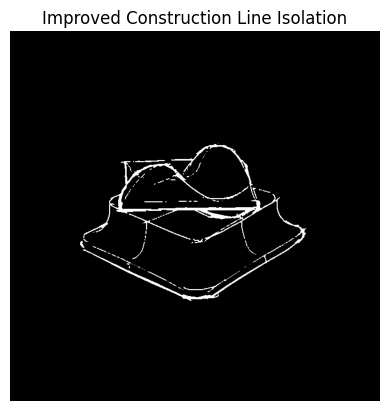

In [ ]:
# Normalize to [0, 1]
full_f = full.astype(np.float32) / 255.0
clean_f = clean.astype(np.float32) / 255.0

# Subtract and threshold
diff = np.clip(full_f - clean_f, 0, 1)
diff_bin = (diff > 0.05).astype(np.uint8) * 255

# Optional smoothing
diff_bin = cv2.medianBlur(diff_bin, 3)

# Show result
plt.imshow(diff_bin, cmap='gray')
plt.title("Improved Construction Line Isolation")
plt.axis('off')
plt.show()

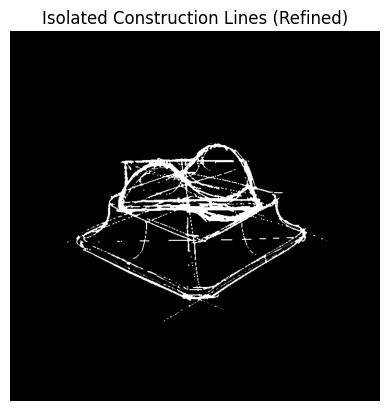

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Normalize to float32 for accurate subtraction
full_f = full.astype(np.float32) / 255.0
clean_f = clean.astype(np.float32) / 255.0

# Use absolute difference to detect variation (construction lines)
diff = np.abs(full_f - clean_f)

# Apply threshold to suppress shared lines (object lines)
mask = (diff > 0.08).astype(np.uint8) * 255

# Optional: clean up noise
mask = cv2.medianBlur(mask, 3)

# Display
plt.imshow(mask, cmap='gray')
plt.title("Isolated Construction Lines (Refined)")
plt.axis('off')
plt.show()
